In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from scipy.ndimage import measurements
from z3 import *

In [2]:
# Learning z3. Like what I see
# couldn't see an obvious place to start 

url='https://www.janestreet.com/puzzles/kenken-concatenated/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
print(" ".join(x[7:9]))

A variant of KenKen: fill each cell with a digit between 1 and 9 so that each row and column contains each digit once.  Like a normal KenKen puzzle, the numbers within each region should form the indicated amount under the given operation.  However, when calculating, horizontally adjacent cells within a region should be concatenated to form a single number.  (E.g., a 2 next to a 3 would become a 23). The answer to this month’s puzzle is the sum of the largest number in each region.  (Still using concatenation:  the largest number in a region may comprise 1, 2, or 3 digits.)


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2017/05/may17_puzzle.png" width="350">

In [3]:
grid = np.array([[20, 20,  1,  1,  1,  2,  2,  3,  3],
                 [20,  4,  4,  4,  1,  2,  5,  5,  3],
                 [ 6,  6,  4,  4,  4,  7,  8,  5,  5],
                 [ 6,  9,  9, 10,  7,  7,  8, 11, 11],
                 [ 9,  9, 10, 10, 12, 12, 12, 11, 13],
                 [14, 14, 14, 10, 15, 15, 12, 13, 13],
                 [14, 14, 14, 15, 15, 12, 12, 16, 13],
                 [17, 18, 18, 18, 19, 19,  0, 16, 16],
                 [17, 17, 18, 19, 19, 19,  0,  0,  0]],dtype=int)


In [4]:
def counter(groups,solved):
    group_poss = []
    for i in range(21):
        group_poss.append([0])
    
    group = 0
    total =0
    for i,j in itertools.product(range(9),range(9)):  
        num = solved[i,j]
        if groups[i,j] == group:
            total *=10
            total += num
        else:
            group_poss[group].append(total)
            group = groups[i,j]
            total = num
    group_poss[group].append(total)
     
    prod = 0
    for i in range(21):
        #print(i,group_poss[i])
        prod +=max(group_poss[i])
        
    return prod

Solved in 205.2969 seconds


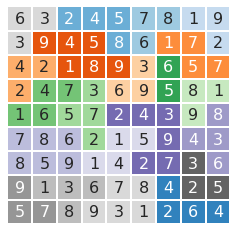

The sum of the squares is : 4,282


In [5]:
start = time.time()
r=[]

######################################################
# Setup # 9x9 matrix of integer variables and solver #
######################################################
X = [[Int("x_%s_%s" % (i+1, j+1)) for j in range(9) ] for i in range(9)]

s = Solver()

###############################
# General Soduku contstraints #
###############################

# each cell contains a value in {1, ..., 9}
s += [And(1 <= X[i][j], X[i][j] <= 9) for i in range(9) for j in range(9)]

 # each row contains a digit at most once
s += [Distinct(X[i]) for i in range(9) ]

# each column contains a digit at most once
s += [Distinct([X[i][j] for i in range(9) ]) for j in range(9)]

########################
# Specific constraints #
########################

s.add((X[0][0]*10+X[0][1]) / X[1][0] == 21) #OK
s.add((X[0][2]*100+X[0][3]*10+X[0][4])*X[1][4]==1960) #OK
s.add((X[0][5]*10+X[0][6])/X[1][5] ==13) #OK ish
s.add(X[0][7]*10+X[0][8]-X[1][8] ==17) #OK
s.add(Or(
     (X[1][1]*100+X[1][2]*10+X[1][3])/(X[2][2]*100+X[2][3]*10+X[2][4])==5,
     (X[1][1]*100+X[1][2]*10+X[1][3])/(X[2][2]*100+X[2][3]*10+X[2][4])==1/5))
s.add((X[1][6]*10+X[1][7])*(X[2][7]*10+X[2][8])==969) # OK
s.add((X[2][0]*10+X[2][1])/X[3][0]==21) # OK
s.add(X[3][4]*10+X[3][5]-X[2][5]==66) #OK
s.add(Or(X[2][6]-X[3][6]==1,X[2][6]-X[3][6]==-1)) # OK
s.add(X[3][1]*10+X[3][2]+X[4][0]*10+X[4][1]==63) # OK
s.add(X[3][3] * (X[4][2]*10+X[4][3])* X[5][3] ==342) # OK
s.add((X[3][7]*10+X[3][8])/X[4][7] == 9) # OK
s.add((X[4][4]*100+X[4][5]*10+X[4][6])*X[5][6]*(X[6][5]*10+X[6][6])==59049) # OK
s.add(Or(
    (X[5][0]*100+X[5][1]*10+X[5][2])-(X[6][0]*100+X[6][1]*10+X[6][2])==73,
     (X[5][0]*100+X[5][1]*10+X[5][2])-(X[6][0]*100+X[6][1]*10+X[6][2])==-73))
s.add(Or(
     (X[5][4]*10+X[5][5])-(X[6][3]*10+X[6][4])==1,
     (X[5][4]*10+X[5][5])-(X[6][3]*10+X[6][4])==-1))
s.add(X[4][8]+(X[5][7]*10+X[5][8])+X[6][8]==57) #OK
s.add((X[7][7]*10+X[7][8])-X[6][7]==22) #OK
s.add(X[8][0]*10+X[8][1]+X[7][0] ==66) #OK      
s.add((X[7][1]*100+X[7][2]*10+X[7][3])/X[8][2]==17)  #OK      
s.add((X[8][3]*100+X[8][4]*10+X[8][5])+X[7][4]*10+X[7][5]==1009) #OK      
s.add((X[8][6]*100+X[8][7]*10+X[8][8])*X[7][6]==1056)    #OK

###################
# Solve and print #
###################
if s.check() == sat:
    m = s.model()
    r = [[ m.evaluate(X[i][j]).as_long() for j in range(9) ] for i in range(9)]
else:
    print("Failed")
stop = time.time()
print("Solved in {:.4f} seconds".format(stop-start))
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax =sns.heatmap(grid,annot=r,cbar=False,cmap="tab20c",fmt="",linewidths=1,annot_kws={"size":16})
ax.axis("off")
plt.show()
print("The sum of the squares is : {:,.0f}".format(counter(grid,np.array(r))))

In [7]:
url='https://www.janestreet.com/puzzles/solutions/may-2017-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The answer to May 2017’s puzzle is 4282 , and the completed puzzle is presented here.  Congratulations to everyone who submitted the correct answer!


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2017/06/May17_solution.png" width="350" >

In [30]:
r = [[6, 3, 2, 4, 5, 7, 8, 1, 9],
       [3, 9, 4, 5, 8, 6, 1, 7, 2],
       [4, 2, 1, 8, 9, 3, 6, 5, 7],
       [2, 4, 7, 3, 6, 9, 5, 8, 1],
       [1, 6, 5, 7, 2, 4, 3, 9, 8],
       [7, 8, 6, 2, 1, 5, 9, 4, 3],
       [8, 5, 9, 1, 4, 2, 7, 3, 6],
       [9, 1, 3, 6, 7, 8, 4, 2, 5],
       [5, 7, 8, 9, 3, 1, 2, 6, 4]]